## Multiclass classification of breast cancer patients - Notebook 2

In this notebook, I applied ensemble algorithm (XGBoost) and built a neural network model (Keras Sequential) to classify and predict the survival rate of patients with breast cancer.

### 1. Prepare Problem

In [1]:
# a) Load libraries

import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import xgboost as xgb

import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# b) Load dataset
raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)
print(raw_data.shape)
print(raw_data.head(10))
print(raw_data.dtypes)

(1904, 693)
   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type  \
0           0             75.65             MASTECTOMY  Breast Cancer   
1           2             43.19      BREAST CONSERVING  Breast Cancer   
2           5             48.87             MASTECTOMY  Breast Cancer   
3           6             47.68             MASTECTOMY  Breast Cancer   
4           8             76.97             MASTECTOMY  Breast Cancer   
5          10             78.77             MASTECTOMY  Breast Cancer   
6          14             56.45      BREAST CONSERVING  Breast Cancer   
7          22             89.08      BREAST CONSERVING  Breast Cancer   
8          28             86.41      BREAST CONSERVING  Breast Cancer   
9          35             84.22             MASTECTOMY  Breast Cancer   

                        cancer_type_detailed cellularity  chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN             0   
1           Breast Invasive Ductal C

D:\Software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 1904 attributes from 693 input fearures. One feature (death_from_cancer) is the output feature for classification.

### 2. Dataset summary

In [3]:
# a) Statistical summary
# print the statistical summary of some columns
set_option('display.width', 100)
set_option('precision', 3)
tempt = raw_data[0:10]
print(tempt.describe())

       patient_id  age_at_diagnosis  chemotherapy  cohort  neoplasm_histologic_grade  \
count      10.000            10.000        10.000    10.0                     10.000   
mean       13.000            68.729         0.400     1.0                      2.500   
std        11.681            17.713         0.516     0.0                      0.527   
min         0.000            43.190         0.000     1.0                      2.000   
25%         5.250            50.765         0.000     1.0                      2.000   
50%         9.000            76.310         0.000     1.0                      2.500   
75%        20.000            82.858         1.000     1.0                      3.000   
max        35.000            89.080         1.000     1.0                      3.000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count           10.000                         10.000           9.000   
mean             0.900                          2.500        

In [4]:
# On classication problems we need to know the balance or the distribution of the class attribute
class_counts = raw_data.groupby('death_from_cancer').size()
print(class_counts)

death_from_cancer
Died of Disease         622
Died of Other Causes    480
Living                  801
dtype: int64


We can see that this dataset is a bit imbalanced with high number of observations of people in Living category (801 out of 1904).

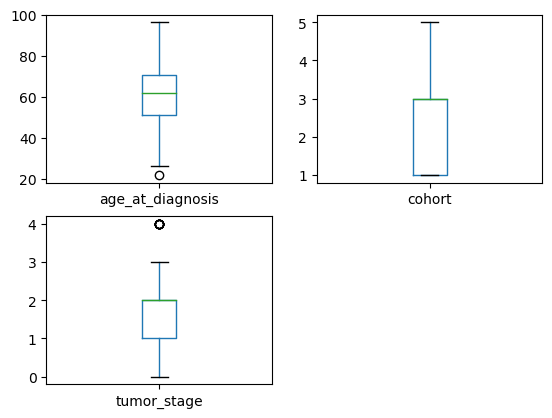

In [5]:
# b) Data visualizations

# Box and Whisker Plots of a few features
raw_plot = pd.DataFrame(raw_data, columns=["age_at_diagnosis", "cellularity", "cohort", "tumor_stage", "death_from_cancer"])
raw_plot.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

cellularity    AxesSubplot(0.125,0.712609;0.168478x0.167391)
dtype: object

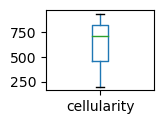

In [6]:
# Box plot for a categorial data
raw_plot['cellularity'].value_counts().plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)

### 3. Prepare Data

In [7]:
# a) Data Cleaning
# Drop useless columns
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


By doppring unimportant columns, the number of features reduces from 693 to 519.

In [8]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

patient_id                 0
age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type                0
cancer_type_detailed      15
                          ..
star                       0
tnk2                       0
tulp4                      0
ugt2b15                    0
ugt2b17                    0
Length: 519, dtype: int64


In [9]:
# Imputation of missing values with 'mode' values in important columns
data["type_of_breast_surgery"]=data["type_of_breast_surgery"].fillna(data["type_of_breast_surgery"].mode()[0])
data["cancer_type_detailed"]=data["cancer_type_detailed"].fillna(data["cancer_type_detailed"].mode()[0])
data["cellularity"]=data["cellularity"].fillna(data["cellularity"].mode()[0])
data["er_status_measured_by_ihc"]=data["er_status_measured_by_ihc"].fillna(data["er_status_measured_by_ihc"].mode()[0])
data["neoplasm_histologic_grade"]=data["neoplasm_histologic_grade"].fillna(data["neoplasm_histologic_grade"].mode()[0])
data["tumor_other_histologic_subtype"]=data["tumor_other_histologic_subtype"].fillna(data["tumor_other_histologic_subtype"].mode()[0])
data["primary_tumor_laterality"]=data["primary_tumor_laterality"].fillna(data["primary_tumor_laterality"].mode()[0])
data["mutation_count"]=data["mutation_count"].fillna(data["mutation_count"].mode()[0])
data["oncotree_code"]=data["oncotree_code"].fillna(data["oncotree_code"].mode()[0])
data["3-gene_classifier_subtype"]=data["3-gene_classifier_subtype"].fillna(data["3-gene_classifier_subtype"].mode()[0])
data["tumor_size"]=data["tumor_size"].fillna(data["tumor_size"].mode()[0])
data["tumor_stage"]=data["tumor_stage"].fillna(data["tumor_stage"].mode()[0])

In [10]:
# drop rows with missing values
data.dropna(inplace=True)
print(data.shape)

(1903, 519)


In [11]:
df = data.copy(deep = True)

# Convert strings into categorial classes
df['type_of_breast_surgery'].replace('BREAST CONSERVING', 1, inplace = True)
df['type_of_breast_surgery'].replace('MASTECTOMY', 0, inplace = True)

df['cellularity'].replace('High', 2, inplace = True)
df['cellularity'].replace('Moderate', 1, inplace = True)
df['cellularity'].replace('Low', 0, inplace = True)

df['er_status_measured_by_ihc'].replace('Positve', 1, inplace = True)
df['er_status_measured_by_ihc'].replace('Negative', 0, inplace = True)

df['her2_status'].replace('Positive', 1, inplace = True)
df['her2_status'].replace('Negative', 0, inplace = True)

df['inferred_menopausal_state'].replace('Post', 1, inplace = True)
df['inferred_menopausal_state'].replace('Pre', 0, inplace = True)

df['pr_status'].replace('Positive', 1, inplace = True)
df['pr_status'].replace('Negative', 0, inplace = True)

# Define class for the classification class "death_from_cancer"
df['death_from_cancer'].replace('Living', 0, inplace = True)
df['death_from_cancer'].replace('Died of Other Causes', 1, inplace = True)
df['death_from_cancer'].replace('Died of Disease', 2, inplace = True)

In [12]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype',\
'tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', '3-gene_classifier_subtype'])
print(df['death_from_cancer'])

0       0
1       0
2       2
3       0
4       2
       ..
1899    0
1900    2
1901    2
1902    1
1903    1
Name: death_from_cancer, Length: 1903, dtype: int64


In [13]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    X = np.array(X)    
    y = np.array(y)
    
    a = best_features['fname']
    b= best_features['score']
    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

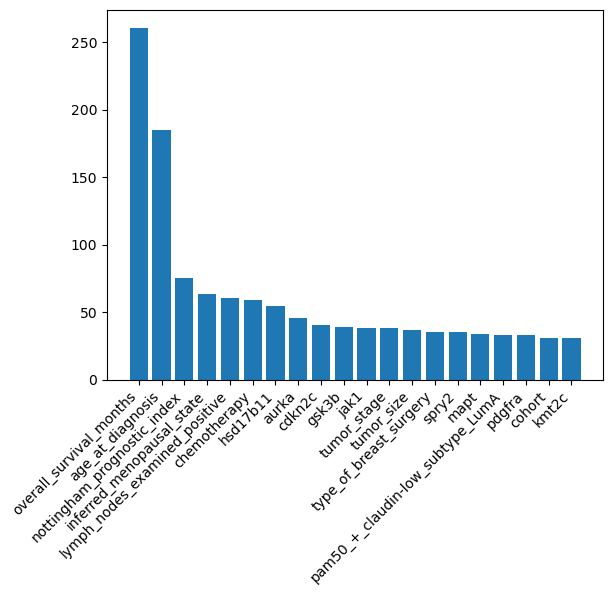

In [14]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'overall_survival'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

The chart clearly shows that 2 features (overall_survival_months and age_of_diagnosis) might be the most relevant (according to test statistic).

In [15]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1332, 20) (571, 20)
(1332,) (571,)


### 4. Evaluate Algorithms

In [16]:
# a) Ensemble algorithm (XGBoost)
# Define model
model1 = XGBClassifier(use_label_encoder=False)

# Use DMatrix to convert input data into internal data structure that is optimized for both memory efficiency and training speed.
df_xgb = xgb.DMatrix(data=X, label=y)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)

model1.fit(X_train1, y_train1)

# make predictions for test data
pred = model1.predict(X_test1)

# evaluate predictions
accuracy = accuracy_score(y_test1, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[22:07:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 65.85%


The training accuracy of the XGBoostClassifier with default parameters is fairly low and is within the range of the standard ML and ensemble algorithms in Notebook 1.

In [17]:
# a) Deep learning model (Keras Sequential)
# Define a model with 3 layers and dropout regulation
NN_model = keras.Sequential([    
    keras.layers.Dense(300, input_shape = (20, ), activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(150, activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='softplus')  
])

NN_model.compile(optimizer = 'adam',
                loss = 'mean_squared_logarithmic_error',
                metrics=['mse'])

In [18]:
# fit the keras model on the dataset
model_fit = NN_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=64)

Epoch 1/50
21/21 [==============================] - 1s 12ms/step - loss: 0.2166 - mse: 0.7368 - val_loss: 0.1929 - val_mse: 0.6524
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 0.1961 - mse: 0.6611 - val_loss: 0.1773 - val_mse: 0.5959
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 0.1836 - mse: 0.6214 - val_loss: 0.1687 - val_mse: 0.6014
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1776 - mse: 0.6106 - val_loss: 0.1600 - val_mse: 0.5580
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1692 - mse: 0.5786 - val_loss: 0.1603 - val_mse: 0.5046
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.1661 - mse: 0.5570 - val_loss: 0.1528 - val_mse: 0.5117
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1595 - mse: 0.5418 - val_loss: 0.1505 - val_mse: 0.4975
Epoch 8/50
21/21 [==============================] - 0s 5ms/step - loss: 0.1588 - mse: 0.5

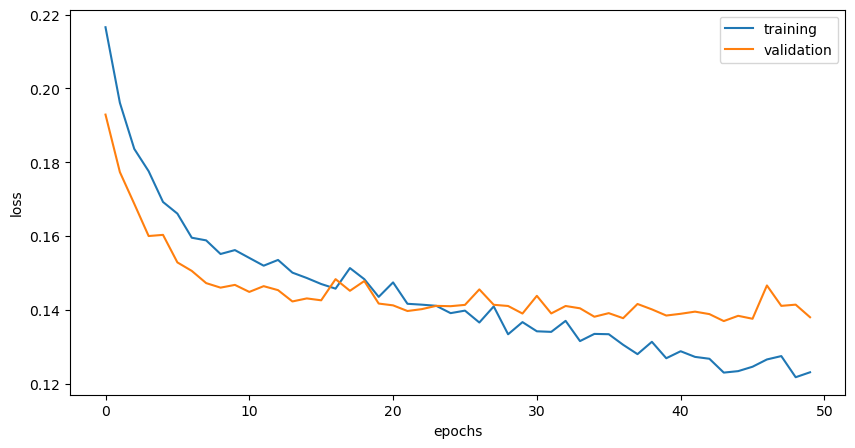

In [19]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(model_fit.history['loss'], label = 'training')
plt.plot(model_fit.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Overall, the training and validation performances of this Keras Sequential model is in good agreement. However, the loss values over 50 epoches are pretty high (0.12 to 0.14) meaning there should be rooms for improvement.

### 5. Improve Accuracy

In [20]:
# Algorithm (XGBoost) Tuning
# Define model
model_XGB = XGBClassifier(use_label_encoder=False)

# Sensitivity parameters
# Tuning Learning Rate and the Number of Trees
lrate = [0.001, 0.01, 0.1]
n_tree = [100, 300, 500]
param_grid = dict(learning_rate=lrate, n_estimators=n_tree)

# Grid search on optimum hyperparameters for XGBooost model
model_XGB_temp = GridSearchCV(estimator=model_XGB, param_grid=param_grid, scoring="neg_log_loss", verbose=1)
grid_result = model_XGB_temp.fit(X_train1, y_train1, eval_metric='rmse')
print("Optimum parameters %s" % (grid_result.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimum parameters {'learning_rate': 0.01, 'n_estimators': 300}


Now we will implement these optimum parameters to retrain and validate the dataset.

### 6. Finalize Model

In [21]:
# a) Predictions on validation dataset
# Define XGBoost model with optimum set of parameters
model_XGB = XGBClassifier(learning_rate = 0.01, n_estimators = 300, use_label_encoder=False)

# Fit the trained model to the valiation data
fit_XGB = model_XGB.fit(X_train1, y_train1)

# estimate accuracy on validation dataset
fit_XGB.score(X_test, y_test1)
pred = fit_XGB.predict(X_test1)

[22:09:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
# Let's see the accuracy score
accuracy = accuracy_score(y_test1, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.08%


Tuning XGBoost model parameters lift the accuracy slightly from 65.85% to 67.08% but still within the range of standard and ensemble ML algorithms.

In [23]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_XGB, open(filename, 'wb'))

### 7. Conclusions

- Staring with the problem statement, we performed exploratory data analysis and cleaning before passing the data into algorithms for training and prediction.


- The ensemble algorithm (XGBoost) with default parameters has a prediction accuracy of 65.85% which is within the range of ML and ensemble algorithms in Notebook 1. Further tuning of the model's parameters (learning rate and tree number) improves its performance slightly to 67.08%.


- The performance of the neural network model (Keras Sequential) with 3 layers and dropput regulation seems to be comparable to the XGBoost model. Loss values of training and prediction are in good agreement but the mean absolute error of 0.4 is fairly high.


- Predictive performances of all ML and deep learning algorithms on this dataset seems to be capped at sub 70s (%). This suggests that more work to be done, such as feature selection, dimensional reduction, and probably other deep leaning algorithms, to improve the training and prediction on this dataset.